In [1]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from seaborn import kdeplot
from scipy import stats

## VaR Subadditivity

In [2]:
x, y = np.array([-1,0]), np.array([.049, .951])
y0, y1 = np.array([0.049, .001]), np.array([0,.95])

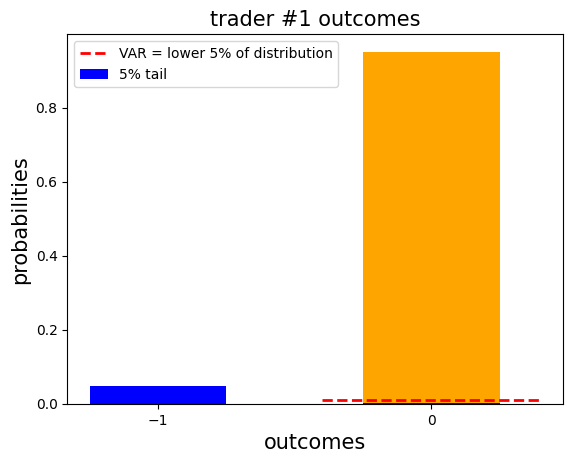

In [3]:
plt.bar(x,y0, width=0.5,color='blue', label='5% tail')
plt.bar(x,y1, bottom=y0, width=0.5,color='orange')
plt.xticks(x)
plt.plot([-.4,.4],[0.01,0.01],'--', linewidth=2.0, color='red', label='VAR = lower 5% of distribution')
plt.title("trader #1 outcomes", fontsize=15)
plt.xlabel('outcomes', fontsize=15)
plt.ylabel('probabilities', fontsize=15)
plt.legend()
plt.show()

In [4]:
probs2 = np.outer(y,y)
outcomes2 = np.add.outer(x,x)
print("probabilities:\n",probs2)
print("\noutcomes:\n", outcomes2)

probabilities:
 [[0.002401 0.046599]
 [0.046599 0.904401]]

outcomes:
 [[-2 -1]
 [-1  0]]


outcomes: [-2 -1  0]
probabilities: [0.002401 0.093198 0.904401]


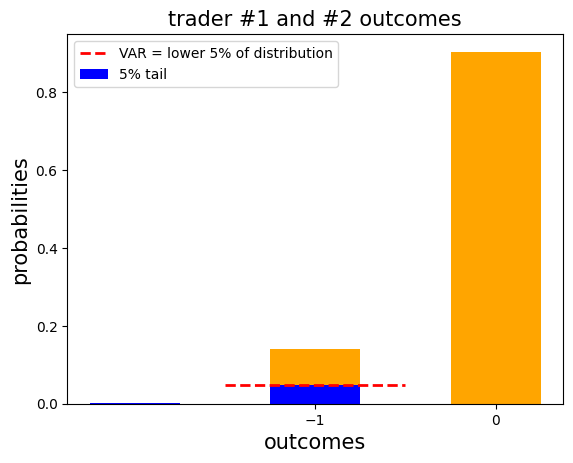

In [5]:
x2= np.array([outcomes2[0][0], outcomes2[0][1], outcomes2[1][1]])
y2= np.array([probs2[0][0], probs2[0][1] + probs2[1][0], probs2[1][1]])

print("outcomes:", x2)
print("probabilities:",y2)

y0, y1 = np.array([y2[0], 0.05-y2[0], 0]), np.array([0,y2[1], y2[2]])

plt.bar(x2,y0, width=0.5,color='blue', label='5% tail')
plt.bar(x2,y1, bottom=y0, width=0.5,color='orange')
plt.xticks(x)
plt.plot([-1.5,-.5],[0.05-y2[0],0.05-y2[0]],'--', linewidth=2.0, color='red', label='VAR = lower 5% of distribution')
plt.title("trader #1 and #2 outcomes", fontsize=15)
plt.xlabel('outcomes', fontsize=15)
plt.ylabel('probabilities', fontsize=15)
plt.legend()
plt.show()

## Expected Tail Loss Subadditivity

In [6]:
print(x)
print(y0)

etl = 0

for i in range(2):
    etl += x[i] * y0[i]
    
print("Expected Tail Loss: ", etl / 2)

[-1  0]
[0.002401 0.047599 0.      ]
Expected Tail Loss:  -0.0012005000000000002


In [7]:
print(probs2[0])
print(outcomes2[0])
etl = 0

for i in range(2):
    etl += probs2[0][i] * outcomes2[0][i]
    
print("Expected Tail Loss: ", etl / 2)

[0.002401 0.046599]
[-2 -1]
Expected Tail Loss:  -0.0257005


## Does this violate subadditivity? 

#### The results show that the subadditivty condition is violated. The expected tail loss has increased. 

## Bitcoin Volatility Modeling 

In [8]:
btc_df = yf.download('BTC-USD', 
                      start='2015-01-01', 
                      end='2023-01-12', 
                      progress=False, auto_adjust=True)

display(btc_df.head())

,Open,High,Low,Close,Volume
Date,,,,,
2015-01-01,320.434998,320.434998,314.002991,314.248993,8036550
2015-01-02,314.079010,315.838989,313.565002,315.032013,7860650
2015-01-03,314.846008,315.149994,281.082001,281.082001,33054400
2015-01-04,281.145996,287.230011,257.612000,264.195007,55629100
2015-01-05,265.084015,278.341003,265.084015,274.473999,43962800


Text(0.5, 1.0, 'Bitcoin Time Series')

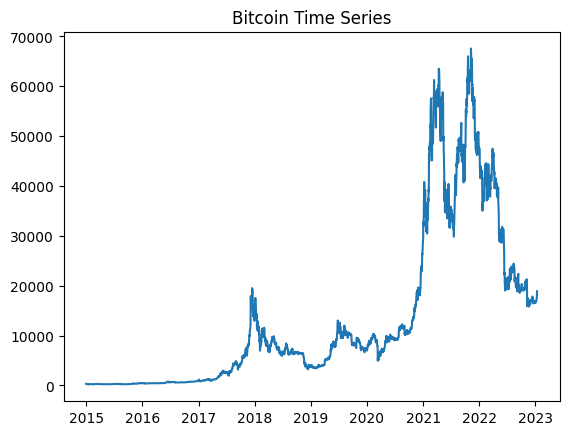

In [9]:
plt.plot(btc_df["Close"])
plt.title("Bitcoin Time Series")

In [10]:
# Compute Log Returns 
L = len(btc_df["Close"])

log_returns = np.zeros(L - 1)
for i in range(L - 1):
    log_returns[i] = np.log(btc_df["Close"][i + 1] / btc_df["Close"][i]) * 100

Text(0.5, 1.0, 'Log Returns')

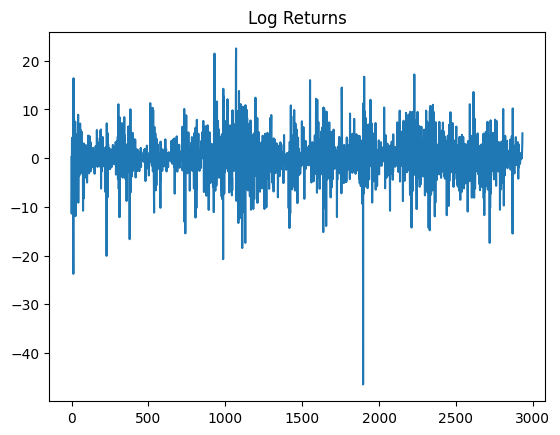

In [11]:
plt.plot(log_returns)
plt.title("Log Returns")

<AxesSubplot: ylabel='Density'>

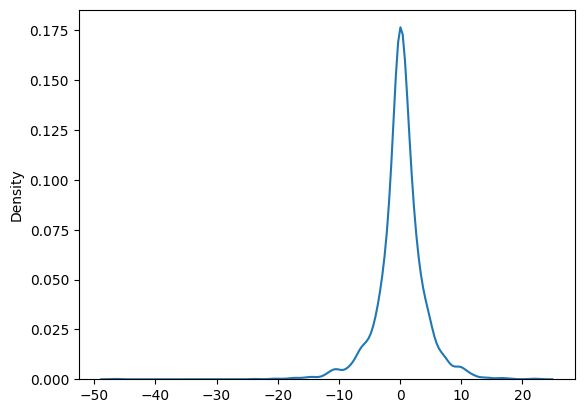

In [12]:
kdeplot(log_returns)

#### Distribution shows fat left tail !!

In [13]:
def compute_kupiec_test(n, m, p):
    
    first_part = -2 * np.log((1 - p)**(n - m) * p**m)
    second_part = 2 * np.log((1 - m / n)**(n - m) * (m / n)**m)
    
    return first_part + second_part

In [14]:
# Compute Exponential Moving Average 
initial_vol = log_returns[0] ** 2 
L = len(log_returns)
ewma = np.zeros(L - 1)
w = 0.94

for i in range(L - 1):
    ewma[i] = ((1 - w) * log_returns[i + 1] ** 2) + (w * initial_vol) 
    initial_vol = ewma[i]

In [15]:
print("Length of Log Returns: ", len(log_returns))
print("Length of EWMA: ", len(ewma))

Length of Log Returns:  2933
Length of EWMA:  2932


Text(0.5, 1.0, 'Exponential Weighted Moving Average')

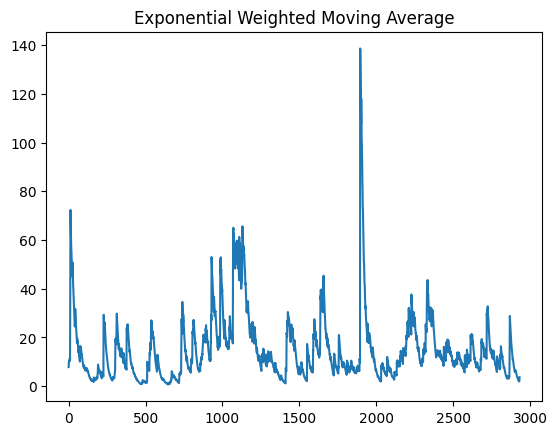

In [16]:
plt.plot(ewma)
plt.title("Exponential Weighted Moving Average")

Text(0.5, 1.0, 'VaR Threshold')

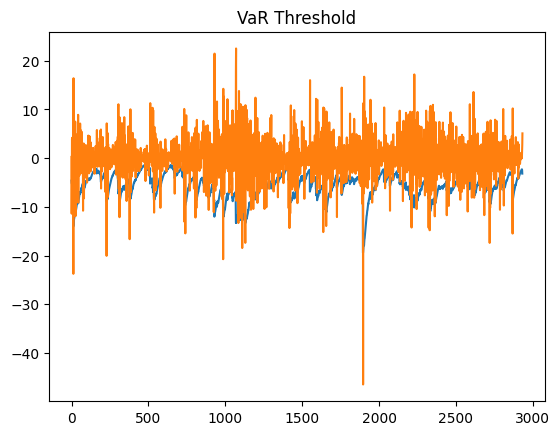

In [17]:
# Compute 95% Var
threshold = -1.65 * np.sqrt(ewma)

plt.plot(threshold)
plt.plot(log_returns)
plt.title("VaR Threshold")

In [18]:
# Count Exceptions
L = len(threshold)
count = 0

for i in range(L):
    if log_returns[i + 1] < threshold[i]:
        count+=1
        
print("Exception Count: ", count)

Exception Count:  118


In [19]:
# Conduct Kupiec Test 
t = compute_kupiec_test(L, count, 0.05)
print("Test Statistic: ", t)

Test Statistic:  6.2751929065644845


## Kupiec Test Statistic 

#### Reject when greater than 3.84

#### This is rejected

In [20]:
# Compute Exponential Moving Average 
initial_vol = log_returns[0] ** 2 
L = len(log_returns)
ewma = np.zeros(L - 1)
w = 0.97

for i in range(L - 1):
    ewma[i] = ((1 - w) * log_returns[i + 1] ** 2) + (w * initial_vol) 
    initial_vol = ewma[i]

Text(0.5, 1.0, 'Exponential Weighted Moving Average')

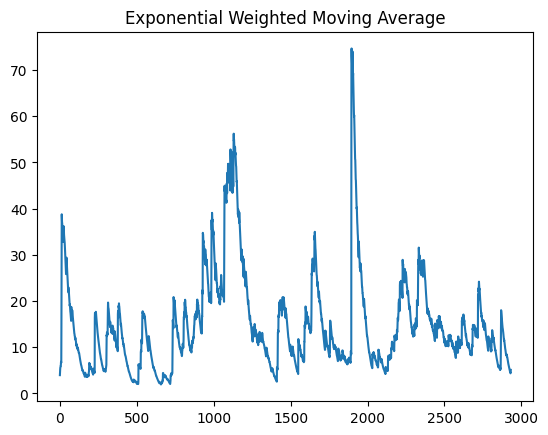

In [21]:
plt.plot(ewma)
plt.title("Exponential Weighted Moving Average")

In [22]:
# Set Volatility for VaR 
sigma = ewma[-1]

Text(0.5, 1.0, 'VaR Threshold')

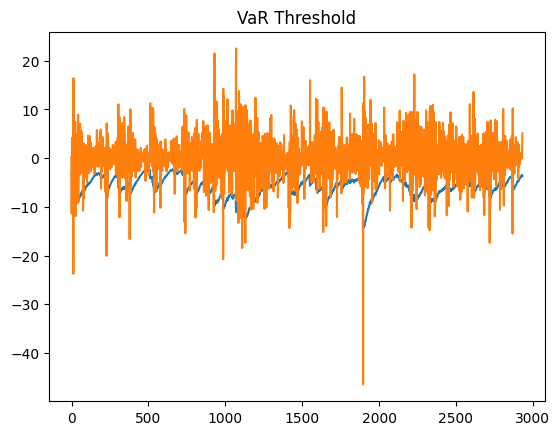

In [23]:
# Compute 95% Var
threshold = -1.65 * np.sqrt(ewma)

plt.plot(threshold)
plt.plot(log_returns)
plt.title("VaR Threshold")

In [24]:
# Count Exceptions
L = len(threshold)
count = 0

for i in range(L):
    if log_returns[i + 1] < threshold[i]:
        count+=1
        
print("Exception Count: ", count)

Exception Count:  117


In [25]:
# Conduct Kupiec Test 
t = compute_kupiec_test(L, count, 0.05)
print("Test Statistic: ", t)

Test Statistic:  6.7385241162974125


## Kupiec Test Statistic 

#### Reject when greater than 3.84

#### This is rejected 

In [26]:
# Compute Exponential Moving Average 
initial_vol = log_returns[0] ** 2 
L = len(log_returns)
ewma = np.zeros(L - 1)
w = 0.70

for i in range(L - 1):
    ewma[i] = ((1 - w) * log_returns[i + 1] ** 2) + (w * initial_vol) 
    initial_vol = ewma[i]

Text(0.5, 1.0, 'Exponential Weighted Moving Average')

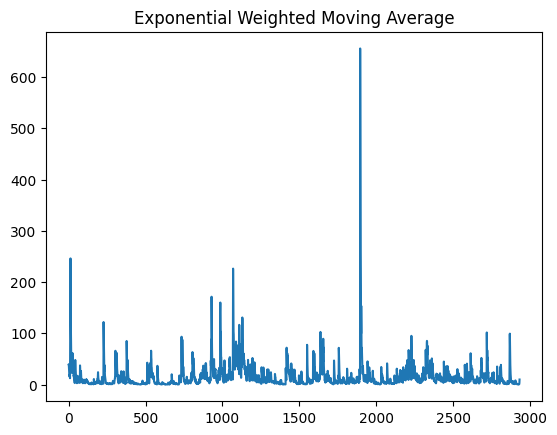

In [27]:
plt.plot(ewma)
plt.title("Exponential Weighted Moving Average")

Text(0.5, 1.0, 'VaR Threshold')

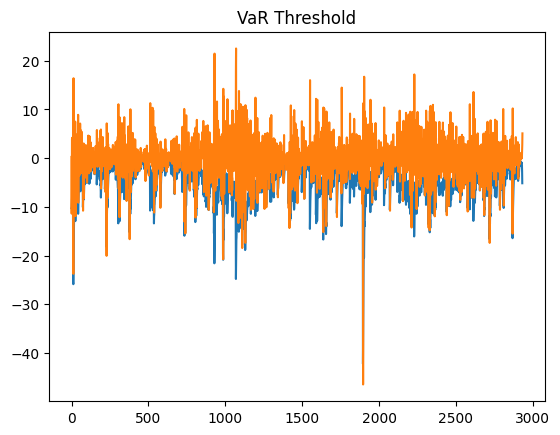

In [28]:
# Compute 95% Var
threshold = -1.65 * np.sqrt(ewma)

plt.plot(threshold)
plt.plot(log_returns)
plt.title("VaR Threshold")

In [29]:
# Count Exceptions
L = len(threshold)
count = 0

for i in range(L):
    if log_returns[i + 1] < threshold[i]:
        count+=1
        
print("Exception Count: ", count)

Exception Count:  54


In [30]:
# Conduct Kupiec Test 
t = compute_kupiec_test(L, count, 0.05)
print("Test Statistic: ", t)

Test Statistic:  80.38274374388493


## Kupiec Test Statistic 

#### Reject when greater than 3.84

#### This is rejected

In [31]:
benchmark_exception_count = int(len(log_returns) *  0.05)
print("Benchmark Exception Count: ", benchmark_exception_count)

Benchmark Exception Count:  146


## VaR Assume Gaussian Distribution 

In [32]:
p = 0.05
std = np.std(log_returns)
VaR = stats.norm.ppf(p) * std
print("Value at Risk: ", VaR)

Value at Risk:  -6.376916172767036


## Lets Assume Portoflio = 10 Million

##  10 Day Expected Tail Loss (95%)

In [33]:
n = 100 
interval = np.linspace(0.95, 0.99999)
area = 0

for i in interval:
    area += stats.norm.ppf(i) * 10
    
integral = area / n

print("10 Day Expected Tail Loss: ", np.sqrt(10 / 252) * integral * (sigma / 100))

10 Day Expected Tail Loss:  0.10590277748921258


## 10 Day VaR (95%)

In [34]:
var1 = np.sqrt(10 / 252) * stats.norm.ppf(0.95) * 10 * (sigma / 100)
print("10 Day VaR: ", var1)

10 Day VaR:  0.1669289078392182


## 10 Day Max VaR (95%)

## Not sure what this is, or how to calculate it. 

## Meta Stock

In [35]:
meta_df = yf.download('META', 
                      start='2023-01-01', 
                      end='2023-02-03', 
                      progress=False, auto_adjust=True)

display(meta_df.head())

,Open,High,Low,Close,Volume
Date,,,,,
2023-01-03,122.820000,126.370003,122.279999,124.739998,35528500
2023-01-04,127.379997,129.050003,125.849998,127.370003,32397100
2023-01-05,126.129997,128.520004,124.540001,126.940002,25447100
2023-01-06,128.970001,130.330002,126.040001,130.020004,27567600
2023-01-09,131.160004,132.949997,129.279999,129.470001,26649100


Text(0.5, 1.0, 'META Time Series')

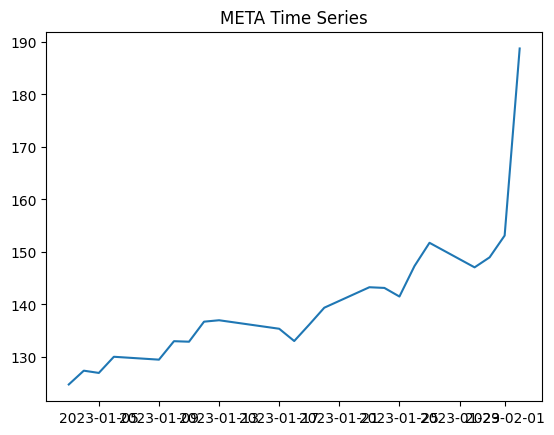

In [36]:
plt.plot(meta_df["Close"])
plt.title("META Time Series")

In [37]:
# Compute Log Returns 
L = len(meta_df["Close"])
meta_returns = np.zeros(L - 1)

for i in range(L - 1):
    meta_returns[i] = np.log(meta_df["Close"][i + 1] / meta_df["Close"][i]) * 100

Text(0.5, 1.0, 'META Log Returns')

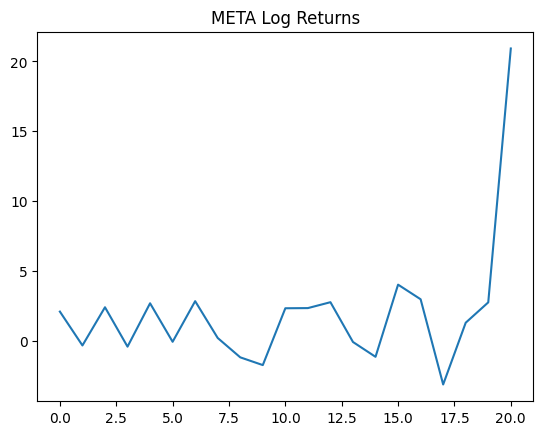

In [38]:
plt.plot(meta_returns)
plt.title("META Log Returns")

## What Happened? 

#### META made a large move to the upside on 2/2/2023

#### This is because the company released their quarterly earnings report. 

#### Stocks tend to make large moves during earnings reports. 